Поздравляю, вы добрались до финальной недели работы над проектом! На этой неделе нужно собрать воедино всё то, над чем вы работали в рамках проекта и подвести итоги вашей работы.

Отчет должен быть интересным, хорошо иллюстрированным и структурированным, его должно “хотеться читать”. Избегайте чересчур объемных отчетов, старайтесь лаконично формулировать мысли и выводы. Отчет можно подготовить как в виде документа, так и в виде презентации, красивого jupyther notebook или даже реализовать небольшое демо.

Отчет нужно сформулировать в таком виде, в котором вы могли бы это делать при работе над аналогичном проектом в компании. Содержание отчета и порядок изложения являются свободными - сделайте так, чтобы ваш отчет выглядел убедительно и демонстрировал вашу работу в лучшем свете. При том, что порядок и стиль изложения не фиксируются, ниже вы найдете рекомендации относительно содержания отчета - перечисленные пункты должны присутствовать, по ним в частности проводится оценка работы. Рекомендуем отразить эти пункты в работе явно, чтобы ваши сокурсники могли легко убедиться в том, что они присутствуют:

1 Цели и задачи проекта. Сформулируйте постановку задачи в терминах машинного обучения, опишите, каким образом ваше решение может быть применено на практике.

2 Методика измерения качества и критерий успеха. Опишите, каким образом, на основании каких метрик вы будете оценивать качество, как будет устроен процесс тестирования модели? Каков критерий успешности?

3 Техническое описание решения. Опишите, как строится модель, какой pipline обработки данных. Здесь отлично будут смотреться схематические иллюстрации!

4 Сделайте выводы о качестве модели, скажите несколько слов об ожидаемом экономическом эффекте от использования модели. Приведите оценки качества, постройте графики, кривые обучения, перечислите лучшие признаки - проявите фантазию. Ваша задача - убедить читателя, что решение хорошее.

5 Подведите итог вашей работы.

Дополнительно можно сформулировать и предложить дизайн онлайн эксперимента, на основании которого можно будет оценить качество работы модели в продакшн. Может быть стоит провести А/Б-тестирование? Каким в этом случае будет дизайн эксперимента? Может быть вы захотите сформулировать предложения по процессу эксплуатации модели, мониторинга за качеством и дообучения модели? Проявите фантазию=)

In [44]:
%matplotlib inline

import warnings
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

warnings.simplefilter("ignore")
PATH_TO_DATA = '../data'

### 1\. Цели и задачи проекта. Сформулируйте постановку задачи в терминах машинного обучения, опишите, каким образом ваше решение может быть применено на практике.

На этом проекте постановка задачи звучит следующим образом:

    "Необходимо по имеющимся сырым данным предсказать отток пользователей (т.е.) прекратит ли пользователь в ближайшее время пользоваться услугами компании."
    
Это достаточно часто применимая на практике задача, так как во многих отраслях (например сотовая связь) стало достаточно сложно привлекать новых клиентов и компании стали более заинтересованы в том что бы удержать тех которые уже имеются.

На практике эта задача может быть решена с помощью математической модели которая будет вычислять пользователей которые в ближайшее время могут потенциально прекратить пользоваться услугами компании и каким-либо бонусным предложением (спец тарифами, скидками и т.д.) которое будет предложено этим пользователям.

Так же стоит отметить что чем раньше будет выявлено что пользователь планирует прекратить пользоваться услугами, тем лучше, т.к. к примеру вернуть пользователя который уже ушел на практике далеко не всегда выполнимая задача, однако если пользователь сомневается, то при получении предложения которое может его заинтересовать он достаточно часто может изменить свое мнение.

Тут так же стоит отметить что есть группа пользователей которая изначально является склонной к оттоку, например если человек покупает сим карту находясь в отпуске и не планирует пользоваться ею по возвращению. Вернуть таких пользователей в большинстве случаев не возможно. Так же для улучшения качества модели необходимо по возможности исключить таких пользователей из обучающей выборки.

### 2. Методика измерения качества и критерий успеха. Опишите, каким образом, на основании каких метрик вы будете оценивать качество, как будет устроен процесс тестирования модели? Каков критерий успешности?

Критерии успеха с точки зрения бизнеса:
 * то что отток пользователей снизился или вообще прекратился
 * то что сокращения оттока удалось добиться с наименьшими финансовыми затратами
 
Критерии с технической точки зрения:
 * то что удалось построить модель которая с высокой точностью определяет пользователей потенциально входящих в группу оттока
 
К сожалению технический критерий на практике не ксегда оценим. Разумеется мы может провести cross-validation подход к построению модели, провести A/B тестирование перед внедрением модели в продакшен, однако дают нам информацию о целесообразности внедрения модели в продакшен, и не дают увериности что при изменении к примеру экономический ситуации на рынке наша модель будет продолжать работать с изначальной точностью. О ток как с этим жить предлагаю поговорить несколько позднее.

#### Метрики по которм будет оцениваться качество модели:

Перед выбором метрики стоит отметить что обучающие выборки оттока как правило не сбалансированые, т.к. мы будет наболюдать сильный перевес объектов с классом "не отток", который иногда может превышать отметку в 10 и более раз. Соответственно такая метрика как accuracy для нас будет абсолютно бессполездной при решении этой задачи.

Основной метрикой будет являться *roc auc curve*, которая позволяет оценивать качество классификатора на несбалансированных выборках.
В качестве дополнительных метрик подходошли бы:
 * $Precision = \frac{TP}{TP+FP}$
 * $Recall=\frac{TP}{TP+FN}$
 
Но для упрощения простоты оптимизации предлагаю использовать F-меру которая является объединением этих метрик:
  
  
<center>$F=2\frac{Precision×Recall}{Precision+Recall}$</center>

### 3 Техническое описание решения. Опишите, как строится модель, какой pipline обработки данных. Здесь отлично будут смотреться схематические иллюстрации!

Заргузим предобработанные данные и посмотрим на первые пару строк

In [27]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, 'new_df_all.train'), index_col=0)
df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var218_cJvF,Var201_6dX3,Var201_smXZ,Var208_kIsH,Var208_sBgB,New_Var191,New_Var224,New_Var215,New_Var213,target
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,-1


Как можно заметить в данных много пропусков, так же есть пустые признаки, все это необходимо обработать.

In [5]:
numeric_cols = ['Var%d' % i for i in range(1, 191)]
cat_cols = [c for c in df.columns if c not in numeric_cols + ['target']]
empty_cols = [c for c in df.columns if df[c].dropna().shape[0] == 0]
numeric_cols = [c for c in numeric_cols if c not in empty_cols]

In [28]:
df = df.fillna(df[numeric_cols].max())

X = df[numeric_cols + cat_cols].values
y = df.target.values

In [35]:
df.target.value_counts()

-1    37024
 1     2976
Name: target, dtype: int64

In [30]:
df.target.value_counts(normalize=True)

-1    0.9256
 1    0.0744
Name: target, dtype: float64

Как и говорилось ранее у нас сильный дисбаланс классов в сторону класса "не отток", значит обычный **KFold** нам не подходит, будем использовать **StratifiedKFold** который умеет решать такие проблемы.

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

Используется достаточно приметивный pipeline который состоит из **StandardScaler**, для улучшения качества градиентного спуска и **PassiveAggressiveClassifier** для обучения.

In [45]:
%%time
estimator = make_pipeline(StandardScaler(), PassiveAggressiveClassifier(C=0.001, random_state=42))
print(cross_val_score(estimator=estimator, cv=skf, X=X, y=y, scoring='roc_auc'))

[ 0.62431515  0.55703153  0.66146812  0.62635013  0.62389306]
Wall time: 4.95 s


Как можно заметить качество не очень высокое, скорее на уровне baseline, но для текущей демонстрации этого достаточно.

### 4 Сделайте выводы о качестве модели, скажите несколько слов об ожидаемом экономическом эффекте от использования модели. Приведите оценки качества, постройте графики, кривые обучения, перечислите лучшие признаки - проявите фантазию. Ваша задача - убедить читателя, что решение хорошее.

#### Кривые обучения

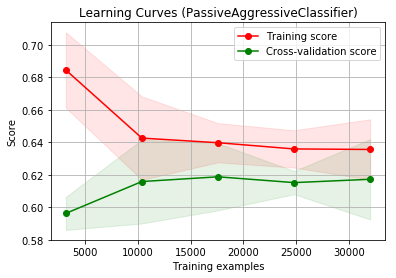

In [42]:
train_sizes = np.linspace(.1, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=skf, n_jobs=-1, 
                                                        train_sizes=train_sizes, scoring='roc_auc')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title('Learning Curves (PassiveAggressiveClassifier)')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
_ = plt.legend(loc="best")

Как можно заметить что после 10 - 15 тысяч сильного именения в качестве модели не наблюдается, этого говорит о том что нет никакой необходимости обучаться на все выборке, для получения результата и успорение процесса достаточно обучиться на ее части.

#### Важнае признаки

In [60]:
estimator = make_pipeline(StandardScaler(), PassiveAggressiveClassifier(C=0.001, random_state=42)).fit(X, y)

sorted_features = pd.Series(abs(estimator.named_steps['passiveaggressiveclassifier'].coef_[0]), index=numeric_cols + cat_cols)\
.sort_values(ascending=False)

print('Top 10 the most important features')
print(sorted_features.head(10))
print()
print('Top 10 the lest important features')
print(sorted_features.tail(10))

Top 10 the most important features
Var168                  0.059400
Var139                  0.050026
Var19                   0.048826
Var218_cJvF             0.042547
Var135                  0.041718
Var126                  0.040569
Var195_I9xt3GMcxUnBZ    0.039123
Var111                  0.037478
Var219_FqMWi1g          0.036379
Var218_UYBR             0.035159
dtype: float64
Top 10 the most important features


Var201_6dX3                   0.000108
Var229_am7c                   0.000107
Var33                         0.000088
Var219_kgEg                   0.000086
Var229_oJmt                   0.000063
Var195_I9xt3Gi01UK7p          0.000049
Var207_tMBVJkA0xJMEATvl4ht    0.000032
Var195_lSbpiq1                0.000019
New_Var191                    0.000018
Var118                        0.000000
dtype: float64

К сожалению логическое значение признаков так и осталось за кадром, что несколько усложняет работу по построению модели.

### 5 Подведите итог вашей работы.

По результатам проекта было проделано:
 
 1. Проведен первичный анализ данних в процессе которого были выявлены пустые, разряженные признаки и линейно зависимые признаки.
 2. Была проведена первичная обработка пропусков, испробованы несколько стратегий обработки категориальных признаков.
 3. Были испробованы модели из различных групп (линейные, деревья, методы опорных векторов).
 4. Бали применены различные методики улучшения качества обучения, например undersampling, class weights.
 5. Были испробованы несколько разных стратегий отбора признаков.

### P.S.

Перед внедрением в продакшен неободимо провести серию A/B эксперементов во время которых можно выяснить на сколько сильно можно уменьшить отток пользователей в случае использования модели. Так же во время этих эксперементов необходимо убедиться что те бонусы которые предлагаются пользователям им подходят. Т.к. в случае если модель будет обладать высокой точностью, но предложение не бодут принято пользователями это так же может привести к недостижению основных бизнес целей описаных выше, а в худшем случае к убыткам компании.

Второй важный момент который необходимо иметь в виду, это то что ситуация на рынке может измениться и необходим постоянный мониторинг того что модель все еще актуальна. Сделать это можно достаточно простым способом, просто отслеживая текущее состояние оттока и в случае если он значительно возрастет протестировать модель на актуальность и при необходимости изменить ее.